## AdaBoost Regression model

linzi yu

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import DataConversionWarning
from sklearn.tree import DecisionTreeRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval

import warnings
warnings.filterwarnings('ignore')

/Users/liny/miniforge3/envs/tf_env/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read in data
X_train = pd.read_csv("../data/scaled_X_train.csv")
y_train = pd.read_csv("../data/scaled_y_train.csv")
X_test = pd.read_csv("../data/scaled_X_test.csv")
y_test = pd.read_csv("../data/scaled_y_test.csv")

# exclude the year column
X_train = X_train.drop(columns = "year")
X_test = X_test.drop(columns = "year")

X_train.head()

,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,1.187014,1.023277,0.984646,0.850506,0.178410,1.221901,-0.004104,-0.036893,0.021631,0.023977,-0.025684
1,1.199637,0.023937,-0.383640,-0.462143,-0.750147,-0.009682,0.026937,0.080594,0.070108,-0.025834,-0.083322
2,-0.572699,-1.057257,-1.294860,-1.396147,-0.280227,-1.590602,-0.473441,-0.440902,-0.402933,-0.376713,-0.337893
3,0.833619,0.072848,0.041553,-0.012319,0.112448,0.760825,-0.216729,-0.353839,-0.324579,-0.287681,-0.215065
4,0.756480,-0.606384,-0.832131,-0.890741,-0.309058,0.428678,-0.623486,-0.444504,-0.301532,-0.277814,-0.221680


## AdaBoost Regressor Modeling

AdaBoost stands for Adaptive Boosting, it is a ensemble algorithm that create a combination model by improving the weights of the weak learners. AdaBoost can be used as a regression model for homeless prediction. 

First, we start by training a baseline AdaBoost Regressor without hyperparameter tuning:

In [55]:
# initialize adaboost regressor
ada_model = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=3), learning_rate=1.0, loss='linear',
         n_estimators=1000, random_state=300) 

# fit the model with training data
ada_model.fit(X_train, y_train)

# train and test prediction 
y_train_pred = ada_model.predict(X_train)
y_test_pred = ada_model.predict(X_test)

#Calculate MSE and R_squared of the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

ada_train_r2 = ada_model.score(X_train, y_train)
ada_test_r2 = ada_model.score(X_test, y_test)

print("AdaBoost Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse,
        test_mse,
    )
)

print(f"\tTrain R-squared\t{ada_train_r2:.4f}")
print(f"\tTest R-squared\t{ada_test_r2:.4f}")

AdaBoost Regressor results:

	Train MSE	0.0200
	Test MSE	0.2352

	Train R-squared	0.9814
	Test R-squared	0.6624


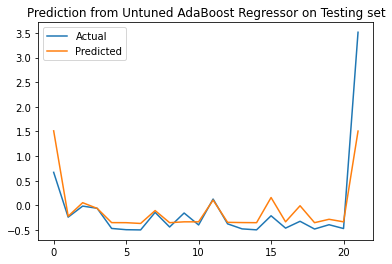

In [23]:
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Actual")
plt.plot(x_ax, y_test_pred, label="Predicted")
plt.title("Prediction from Untuned AdaBoost Regressor on Testing set")
plt.legend()
plt.show()

Feature importance:

Text(0.5, 1.0, 'AdaBoost Regressor feature importance')

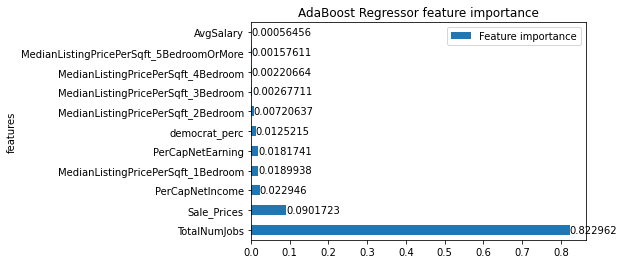

In [45]:
feature_importances_plot = list(zip(list(X_train.columns), ada_model.feature_importances_))
feature_importances_plot = sorted(feature_importances_plot, key=lambda x:x[1], reverse=True)
feature_importances_plot_df = pd.DataFrame(feature_importances_plot, columns=['features', "Feature importance"])

ax = feature_importances_plot_df.plot.barh(x="features", y="Feature importance")
for container in ax.containers:
    ax.bar_label(container)
plt.title("AdaBoost Regressor feature importance")

The performance is already much better than the baseline model. Now, tune the hyper paramaters

In [62]:
# !!! This code cell takes about 5 mins to run
warnings.filterwarnings('ignore')

# space for hyperparameter tuning
space = {
        "base_estimator": hp.choice("base_estimator", [DecisionTreeRegressor(max_depth=2), DecisionTreeRegressor(max_depth=3), DecisionTreeRegressor(max_depth=4)]),
        'n_estimators':hp.choice('n_estimators', np.arange(1, 200, 1, dtype=int)),
        "learning_rate": hp.choice('learning_rate', [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]),
        'loss': hp.choice('loss', ['linear', 'square', 'exponential'])
        }

hypopt_scores = []

def score(params):
    model = AdaBoostRegressor(**params)
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    
    hypopt_scores.append(score**2)
    
    return {'loss': score, 'status': STATUS_OK}    

def optimize(trials, space):
    best = fmin(score, space, algo=tpe.suggest, max_evals=1000)
    return best

trials = Trials()
best_params = optimize(trials, space)

# Return the best parameters
space_eval(space, best_params)


100%|██████████| 1000/1000 [00:37<00:00, 26.66trial/s, best loss: 0.3498421673818856]


{'base_estimator': DecisionTreeRegressor(max_depth=4),
 'learning_rate': 0.01,
 'loss': 'exponential',
 'n_estimators': 17}

In [63]:
best_params

{'base_estimator': 2, 'learning_rate': 2, 'loss': 2, 'n_estimators': 16}

fit the best model with the selected hyperparameters

In [66]:
best_params = {'base_estimator': DecisionTreeRegressor(max_depth=4),
 'learning_rate': 0.01,
 'loss': 'exponential',
 'n_estimators': 17}

best_adamodel = AdaBoostRegressor(**best_params)
best_adamodel.fit(X_train, y_train)


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=4),
                  learning_rate=0.01, loss='exponential', n_estimators=17)

In [67]:
# prediction
y_train_pred_best = best_adamodel.predict(X_train)
y_test_pred_best = best_adamodel.predict(X_test)

# calculate MSE and R_squared of the model
train_mse_best = mean_squared_error(y_train, y_train_pred_best)
test_mse_best = mean_squared_error(y_test, y_test_pred_best)

train_r2_best = best_adamodel.score(X_train, y_train)
test_r2_best = best_adamodel.score(X_test, y_test)

print("Hyperparameter Tuned AdaBoost Regressor results:\n")
print(
    "\tTrain MSE\t{:.4f}\n"
    "\tTest MSE\t{:.4f}\n".format(
        train_mse_best,
        test_mse_best,
    )
)

print(f"\tTrain R-squared\t{train_r2_best:.4f}")
print(f"\tTest R-squared\t{test_r2_best:.4f}")

Hyperparameter Tuned AdaBoost Regressor results:

	Train MSE	0.0200
	Test MSE	0.1800

	Train R-squared	0.9814
	Test R-squared	0.7416


# Feature Importance

The plot below shows feautre importance in terms of the number of times a feature appears in a tree. 

Text(0.5, 1.0, 'AdaBoost Regressor feature importance')

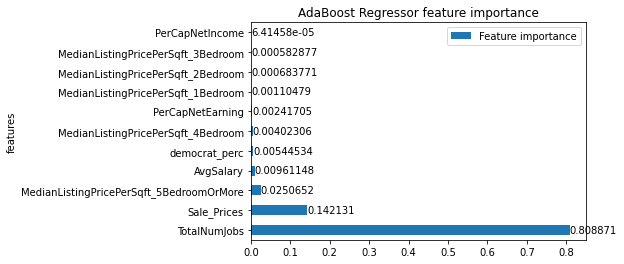

In [69]:
feature_importances_plot = list(zip(list(X_train.columns), best_adamodel.feature_importances_))
feature_importances_plot = sorted(feature_importances_plot, key=lambda x:x[1], reverse=True)
feature_importances_plot_df = pd.DataFrame(feature_importances_plot, columns=['features', "Feature importance"])

ax = feature_importances_plot_df.plot.barh(x="features", y="Feature importance")
for container in ax.containers:
    ax.bar_label(container)
plt.title("AdaBoost Regressor feature importance")